In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import clip
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**Dataset**

In [2]:
from VQA_Dataset import VQA_Dataset
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

dataset = VQA_Dataset()
dataset.load_all(preprocess, length=200, device=device)

#Testing dataset
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

for element in tqdm(dataloader, desc="Testing"):
    id = element['image_id']
    if id == 26216:
        print(element["question"])#, "question: ", i['question_tokens'], "answer: ", i['answer_tokens'])

Testing: 100%|██████████| 200/200 [00:00<00:00, 3834.02it/s]

['Is the man tell the girl to slide down?']
["Is the man old enough to be the girl's grandfather?"]
['What color is the slide?']


**Test-train split**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train size:  160
Test size:  40


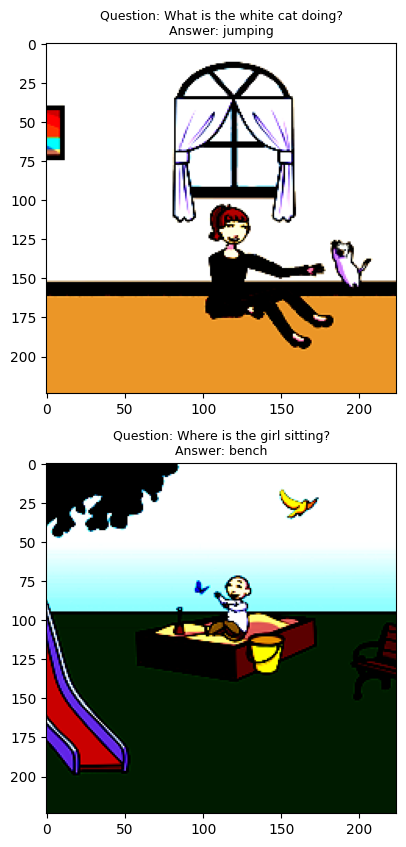

In [3]:
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

train_size = int(len(dataset)*0.8)
test_size = int(len(dataset))-train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print("Train size: ", train_size)
print("Test size: ", test_size)

batch_size=2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#Checking data
fig=plt.figure(0, (18, 10))
for element in train_dataloader:
    for i in range(batch_size):
        ax = fig.add_subplot(2,int(batch_size/2),i+1)
        
        ax.imshow(np.transpose(element["image"][i].squeeze(0).cpu(), (1, 2, 0))) #Converting to matplotlib format
        ax.set_title("Question: "+str(element["question"][i])+"\nAnswer: "+str(element["correct_answer_text"][i]), fontsize=9)
    break

**Model**

In [4]:
from models import VQA_Model2
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else b"cpu"#mps stands for matrix product states, basically enables high-performance training
print("Using: ", device)

#CLIP
clip_model, preprocess = clip.load('ViT-B/32', device)
vqa_model = VQA_Model2(clip_model, device)

Using:  cuda


In [5]:
import os
from PIL import Image
from torchvision import transforms

img = Image.open(os.path.join("Images", "abstract_v002_val2015_000000029903.png"))
image_input = preprocess(img).unsqueeze(0).to(device)
print("Image preprocessed: ",image_input.shape)

image_features = clip_model.encode_image(image_input)
print("Image encoded size: ", image_features.shape)

text = clip.tokenize(["a diagram of the dof" , "a dog", "a cat"]).to(device)
print("Text tokenized size: ",text.shape)

text_features = clip_model.encode_text(text)
print("Text encoded size: ",text_features.shape)

Image preprocessed:  torch.Size([1, 3, 224, 224])
Image encoded size:  torch.Size([1, 512])
Text tokenized size:  torch.Size([3, 77])
Text encoded size:  torch.Size([3, 512])


**Optim**

In [6]:
from torch import nn
loss_fn = nn.CrossEntropyLoss()#Hace el softmax y la funcion costo al mismo tiempo
optimizer = torch.optim.Adam(vqa_model.parameters(), lr=1e-3)

In [7]:
def train(dataloader, vqa_model, loss_function, optimizer, epoch):
    size = len(dataloader.dataset)
    vqa_model.train()
    for batch, (data) in enumerate(dataloader):
        
        images = data["image"].squeeze(1)
        question_tokens = data["question_tokens"].squeeze(1)
        answer_tokens = data["answer_tokens"].squeeze(1)
        similarity_pred = vqa_model(images, question_tokens, answer_tokens)

        similarity_label_arg = data["correct_answer_idx"].to(device)
        
        loss = loss_function(similarity_pred, similarity_label_arg)

        # #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
train(train_dataloader, vqa_model, loss_fn, optimizer, 5)

KeyboardInterrupt: 

In [ ]:
def test(dataloader, model, loss_function,t):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y = y.type(torch.LongTensor)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_function(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    writer.add_scalar('test accuracy', correct*100, t)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")